In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

!pip install einops
from einops import rearrange

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00


In [3]:
img = torchvision.io.read_image("/kaggle/input/taj-dataset/Taj.jpg")
print(img.shape)

torch.Size([3, 2874, 1617])


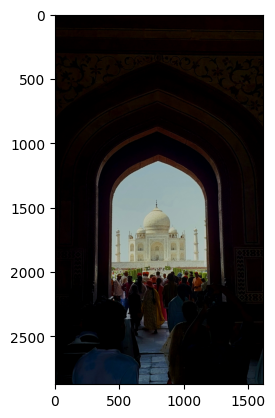

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [7]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.0000, 0.0000, 0.0048,  ..., 0.0095, 0.0095, 0.0238],
         [0.0000, 0.0000, 0.0000,  ..., 0.0095, 0.0095, 0.0286],
         [0.0000, 0.0000, 0.0000,  ..., 0.0095, 0.0095, 0.0286],
         ...,
         [0.0429, 0.0429, 0.0476,  ..., 0.0667, 0.0714, 0.0762],
         [0.0571, 0.0524, 0.0571,  ..., 0.0667, 0.0667, 0.0714],
         [0.0619, 0.0571, 0.0619,  ..., 0.0667, 0.0667, 0.0810]],

        [[0.0000, 0.0000, 0.0048,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0571, 0.0571, 0.0619,  ..., 0.1667, 0.1714, 0.1762],
         [0.0619, 0.0571, 0.0619,  ..., 0.1667, 0.1667, 0.1619],
         [0.0667, 0.0619, 0.0667,  ..., 0.1667, 0.1667, 0.1667]],

        [[0.0000, 0.0000, 0.0048,  ..., 0.0048, 0.0048, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0048, 0.0048, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0048, 0.0048, 0.

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 1630, 640, 300, 300)
crop.shape

torch.Size([3, 300, 300])

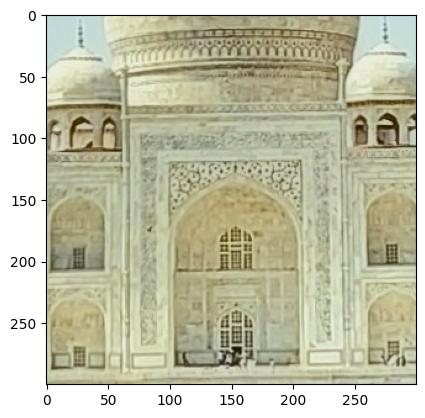

In [9]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [10]:
crop = crop.to(device)

In [11]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [12]:
num_channels, height, width = 2, 3, 4

    
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)

# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()

In [13]:
X.shape

torch.Size([12, 2])

In [14]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [15]:
taj_X, taj_Y = create_coordinate_map(crop)

taj_X.shape, taj_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [16]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(taj_X.cpu())

# Scale the X coordinates
taj_X_scaled = scaler_X.transform(taj_X.cpu())

# Move the scaled X coordinates to the GPU
taj_X_scaled = torch.tensor(taj_X_scaled).to(device)

# Set to dtype float32
taj_X_scaled = taj_X_scaled.float()

In [17]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [18]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [20]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [21]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [22]:
X_rff = create_rff_features(taj_X_scaled, 37500, 0.008)


In [23]:
X_rff.shape

torch.Size([90000, 37500])

In [24]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, taj_Y, 2500)

Epoch 0 loss: 0.456748
Epoch 100 loss: 0.051434
Epoch 200 loss: 0.004288
Epoch 300 loss: 0.001412
Epoch 400 loss: 0.001008
Epoch 500 loss: 0.000865
Epoch 600 loss: 0.000804
Epoch 700 loss: 0.000774
Epoch 800 loss: 0.000759
Epoch 900 loss: 0.000750
Epoch 1000 loss: 0.000743
Epoch 1100 loss: 0.000739
Epoch 1200 loss: 0.000735
Epoch 1300 loss: 0.000732
Epoch 1400 loss: 0.000729
Epoch 1500 loss: 0.000727
Epoch 1600 loss: 0.000725
Epoch 1700 loss: 0.000723
Epoch 1800 loss: 0.000721
Epoch 1900 loss: 0.000720
Epoch 2000 loss: 0.000718
Epoch 2100 loss: 0.000717
Epoch 2200 loss: 0.000716
Epoch 2300 loss: 0.000715
Epoch 2400 loss: 0.000714


0.0007128025754354894

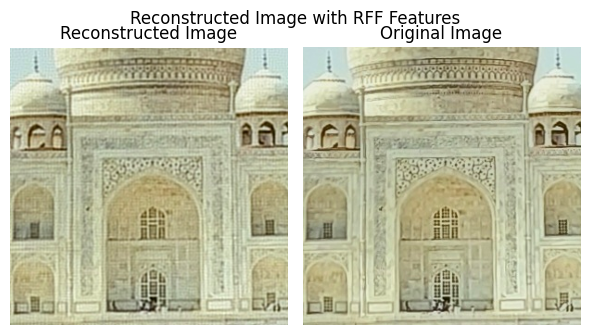

In [25]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")


In [26]:
num_channels, height, width = crop.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(num_channels, height, width)

In [27]:
from torch import nn
criterion = nn.MSELoss()
loss = torch.sqrt(criterion(outputs, crop))
print("RMSE: ",loss.item())

RMSE=  0.20307742967618708


In [28]:
from torchmetrics.image import PeakSignalNoiseRatio
psnr = PeakSignalNoiseRatio().to(device)
psnr_db = psnr(outputs, crop)
print("PSNR: ",psnr_db.item())

PSNR=  13.46630150177361
